<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    02 – Cluster-Level Weather Scenarios
  </span>
</h3>

This notebook combines:
- **clustered station-level trip data** (from the spatial clustering step), and  
- **cleaned hourly weather data** exported from the previous notebook (`01_weather_demand_exploratory.ipynb`)

so that we can analyse **how weather affects each spatial cluster of stations**.

### Objectives of this notebook:
1. Load the cleaned weather datasets (`demand_core.csv`, `weather_hourly_clean.csv`).  
2. Load the trip-level dataset with cluster labels (`ClusteringData.csv`).  
3. Convert trip timestamps into hourly pickups **per cluster**.  
4. Join cluster-level demand with hourly weather.  
5. Build **scenario tables for each cluster**, similar to the scenario logic of Notebook 01.  
6. Prepare results for the final report (cluster-specific business rules).

All paths and files were prepared in the previous notebook, following a reproducible structure inside:

`../data/Weather_Data/weather_core/`  
`../data/Clustering/ClusteringData.csv`

This notebook assumes:
- weather data represent city-wide weather conditions (uniform for all clusters),
- clustering step has already assigned `start_cluster_20` (or similar) to each trip,
- timestamps are in NY local time and consistent with the weather dataset.

Let's begin by loading the datasets.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
weather_core_dir = "../data/Weather_Data/weather_core/"

path_demand_core = os.path.join(weather_core_dir, "demand_core.csv")
path_weather_clean = os.path.join(weather_core_dir, "weather_hourly_clean.csv")

demand_core = pd.read_csv(path_demand_core, parse_dates=["datetime_hour"])
weather_hourly = pd.read_csv(path_weather_clean, parse_dates=["datetime_hour"])

print("Loaded demand_core:", demand_core.shape)
print("Loaded weather_hourly_clean:", weather_hourly.shape)

cluster_path = "../data/Clustering/Clustering_Data.csv"

cluster_df = pd.read_csv(cluster_path, parse_dates=["start_time", "stop_time"])

print("Loaded clustering dataset:", cluster_df.shape)

# Quick preview
demand_core.head(), weather_hourly.head(), cluster_df.head()


Loaded demand_core: (8393, 14)
Loaded weather_hourly_clean: (8393, 10)
Loaded clustering dataset: (17480683, 15)


(        datetime_hour  pickups  temp_C  precip_in  wind_speed_kn  rhum  \
 0 2018-01-01 01:00:00      167    -9.4        0.0       2.915768  64.0   
 1 2018-01-01 02:00:00       98   -10.0        0.0       4.103673  61.0   
 2 2018-01-01 03:00:00       72   -10.6        0.0       2.915768  58.0   
 3 2018-01-01 04:00:00       34   -10.6        0.0       4.103673  70.0   
 4 2018-01-01 05:00:00       26   -10.6        0.0       6.047518  67.0   
 
    is_rain  is_snow_like  is_dry  hour  dow  is_weekend  month temp_bin  
 0    False         False    True     1    0       False      1       <0  
 1    False         False    True     2    0       False      1       <0  
 2    False         False    True     3    0       False      1       <0  
 3    False         False    True     4    0       False      1       <0  
 4    False         False    True     5    0       False      1       <0  ,
         datetime_hour  temp_C  precip_in  is_rain  is_snow_like  is_dry  hour  \
 0 2018-01-01 0

<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    2. Building Hourly Cluster Demand (Pickups per Cluster per Hour)
  </span>
</h3>

To integrate clustering insights with weather–based demand scenarios, we first </br>
need to transform the trip-level clustering dataset into an hourly cluster-level </br>
time series.

Each row in the clustering dataset corresponds to a single trip. By aggregating </br>
these trips at the **(datetime_hour, cluster_id)** level, we obtain a clean and </br>
analysis-ready structure that captures *how many bikes were picked up in each </br>
cluster during each hour*.

This step performs the following:

- Converts `start_time` to a floored hourly timestamp (`datetime_hour`)
- Groups trips by hour and cluster (`start_cluster_20`)
- Counts the number of pickups within each cluster-hour
- Produces a compact table:

  **`[ datetime_hour | cluster_id | pickups_cluster ]`**

This table forms the basis for merging cluster demand with hourly weather </br>
conditions and scenario multipliers in subsequent steps.


In [4]:
# Build hourly pickups per cluster

# 2.1 Convert start_time to hourly bucket
cluster_df["datetime_hour"] = cluster_df["start_time"].dt.floor("H")

# 2.2 Group trips per hour per cluster
cluster_hourly = (
    cluster_df
    .groupby(["datetime_hour", "start_cluster_20"])
    .size()
    .reset_index(name="pickups_cluster")
)

# Rename for clarity
cluster_hourly = cluster_hourly.rename(columns={"start_cluster_20": "cluster_id"})

print("cluster_hourly shape:", cluster_hourly.shape)
cluster_hourly.head(10)

C:\Users\Georg\AppData\Local\Temp\ipykernel_22260\156389775.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cluster_df["datetime_hour"] = cluster_df["start_time"].dt.floor("H")


cluster_hourly shape: (152924, 3)


,datetime_hour,cluster_id,pickups_cluster
0,2018-01-01,0,11
1,2018-01-01,1,7
2,2018-01-01,2,9
3,2018-01-01,3,7
4,2018-01-01,4,13
5,2018-01-01,6,3
6,2018-01-01,8,3
7,2018-01-01,9,5
8,2018-01-01,10,2
9,2018-01-01,11,3


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    3. Merge of Cluster-Hourly Demand with Hourly Weather Conditions
  </span>
</h3>

After computing hourly demand for every cluster, the next step is to enrich this
cluster-level time series with the corresponding weather conditions.

Because weather is identical across all of NYC (one weather station), the merge
is performed using a simple join on:

- <code>datetime_hour</code>

The result is a unified table where *each row represents one cluster at one hour*,
augmented with:

- temperature and precipitation values  
- rain / snow / dry condition flags  
- temporal indicators (hour, day-of-week, month)  
- the cluster’s hourly pickups  

This enriched dataset forms the foundation for all subsequent analysis steps,
including the computation of **cluster-specific weather sensitivity multipliers**.


In [5]:
cluster_weather = cluster_hourly.merge(
    weather_hourly,
    on="datetime_hour",
    how="inner"
)

print(cluster_weather.shape)
cluster_weather.head(20)


(146842, 12)


,datetime_hour,cluster_id,pickups_cluster,temp_C,precip_in,is_rain,is_snow_like,is_dry,hour,dow,is_weekend,month
0,2018-01-01 01:00:00,0,6,-9.4,0.0,False,False,True,1,0,False,1
1,2018-01-01 01:00:00,1,11,-9.4,0.0,False,False,True,1,0,False,1
2,2018-01-01 01:00:00,2,10,-9.4,0.0,False,False,True,1,0,False,1
3,2018-01-01 01:00:00,3,4,-9.4,0.0,False,False,True,1,0,False,1
4,2018-01-01 01:00:00,4,18,-9.4,0.0,False,False,True,1,0,False,1
5,2018-01-01 01:00:00,5,3,-9.4,0.0,False,False,True,1,0,False,1
6,2018-01-01 01:00:00,6,2,-9.4,0.0,False,False,True,1,0,False,1
7,2018-01-01 01:00:00,8,4,-9.4,0.0,False,False,True,1,0,False,1
8,2018-01-01 01:00:00,9,10,-9.4,0.0,False,False,True,1,0,False,1
9,2018-01-01 01:00:00,10,2,-9.4,0.0,False,False,True,1,0,False,1


In [ ]:
#  Recompute temperature bins (needed for scenario grouping) 

def bin_temperature(temp):
    if temp < 0:
        return "<0"
    elif 0 <= temp < 5:
        return "0-5"
    elif 5 <= temp < 10:
        return "5-10"
    elif 10 <= temp < 15:
        return "10-15"
    elif 15 <= temp < 20:
        return "15-20"
    elif 20 <= temp < 25:
        return "20-25"
    elif 25 <= temp < 30:
        return "25-30"
    else:
        return ">30"

cluster_weather["temp_bin"] = cluster_weather["temp_C"].apply(bin_temperature)

print("Added temp_bin. Unique values:", cluster_weather["temp_bin"].unique())

Added temp_bin. Unique values: ['<0' '0-5' '5-10' '10-15' '15-20' '20-25' '25-30' '>30']


In [7]:
print(cluster_weather[cluster_weather["datetime_hour"] == "2018-01-01 01:00:00"].head())



        datetime_hour  cluster_id  pickups_cluster  temp_C  precip_in  \
0 2018-01-01 01:00:00           0                6    -9.4        0.0   
1 2018-01-01 01:00:00           1               11    -9.4        0.0   
2 2018-01-01 01:00:00           2               10    -9.4        0.0   
3 2018-01-01 01:00:00           3                4    -9.4        0.0   
4 2018-01-01 01:00:00           4               18    -9.4        0.0   

   is_rain  is_snow_like  is_dry  hour  dow  is_weekend  month temp_bin  
0    False         False    True     1    0       False      1       <0  
1    False         False    True     1    0       False      1       <0  
2    False         False    True     1    0       False      1       <0  
3    False         False    True     1    0       False      1       <0  
4    False         False    True     1    0       False      1       <0  


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    4. Computation of Cluster-Specific Weather Demand Multipliers
  </span>
</h3>

With the cluster–weather dataset prepared, we now quantify how sensitive each 
cluster is to different weather conditions.  

The goal of this step is to compute **demand multipliers** for every cluster, under
each scenario combination:

- <code>day_type</code> (weekday / weekend)  
- <code>temp_bin</code> (temperature ranges)  
- <code>rain_flag</code> (dry / rain / snow-like)

For each cluster and scenario we calculate:

- the **baseline demand** (dry, 10–15°C, weekday)  
- the **observed mean demand** under the scenario  
- the **multiplier**:  
  <code>multiplier = scenario_mean / baseline_mean</code>  

This produces a table where every row corresponds to:
  
- a cluster  
- a specific weather scenario  
- its relative expected demand  

These multipliers allow the system to later estimate how many pickups a cluster
will receive under any weather condition, enabling downstream applications such as:
  
- weather-adjusted rebalancing  
- staff allocation planning  
- cluster-level forecasting  


In [8]:
# Compute cluster-specific multipliers

# 1. Define baseline scenario for every cluster
baseline_mask = (
    (cluster_weather["is_dry"] == True) &
    (cluster_weather["temp_C"].between(10, 15)) &
    (cluster_weather["dow"].between(0, 4))  # weekday
)

baseline = (
    cluster_weather[baseline_mask]
    .groupby("cluster_id")["pickups_cluster"]
    .mean()
    .rename("baseline_mean")
)

print("Baseline computed for clusters:", baseline.shape)

# 2. Add baseline into main table
cluster_weather = cluster_weather.merge(
    baseline,
    on="cluster_id",
    how="left"
)

# 3. Create scenario grouping fields
cluster_weather["day_type"] = cluster_weather["dow"].apply(
    lambda x: "weekend" if x >= 5 else "weekday"
)

cluster_weather["rain_flag"] = cluster_weather.apply(
    lambda row: "rain" if row["is_rain"] else ("snow" if row["is_snow_like"] else "dry"),
    axis=1
)

# temp_bin already exists, but ensure fast string for grouping
cluster_weather["temp_bin"] = cluster_weather["temp_bin"].astype(str)

# 4. Compute scenario mean per cluster
scenario_means = (
    cluster_weather.groupby(
        ["cluster_id", "day_type", "temp_bin", "rain_flag"]
    )["pickups_cluster"]
    .mean()
    .rename("scenario_mean")
    .reset_index()
)

# 5. Merge scenario means with baseline
scenario_table = scenario_means.merge(
    baseline.reset_index(),
    on="cluster_id",
    how="left"
)

# 6. Compute multipliers
scenario_table["multiplier"] = (
    scenario_table["scenario_mean"] / scenario_table["baseline_mean"]
)

print("Scenario table shape:", scenario_table.shape)
scenario_table.head(20)


Baseline computed for clusters: (18,)
Scenario table shape: (612, 7)


,cluster_id,day_type,temp_bin,rain_flag,scenario_mean,baseline_mean,multiplier
0,0,weekday,0-5,dry,113.974874,190.05973,0.599679
1,0,weekday,0-5,rain,77.042328,190.05973,0.405359
2,0,weekday,0-5,snow,83.400000,190.05973,0.438809
3,0,weekday,10-15,dry,188.038710,190.05973,0.989366
4,0,weekday,10-15,rain,149.592593,190.05973,0.787082
5,0,weekday,15-20,dry,241.172906,190.05973,1.268932
6,0,weekday,15-20,rain,208.100000,190.05973,1.094919
7,0,weekday,20-25,dry,260.109840,190.05973,1.368569
8,0,weekday,20-25,rain,249.440000,190.05973,1.312430
9,0,weekday,25-30,dry,273.640514,190.05973,1.439761


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    5. Cleaning and Preparing the Cluster-Level Scenario Table
  </span>
</h3>

The raw scenario table produced in Step 4 contains demand multipliers for every </br>
cluster under each weather category. However, not all scenario combinations are </br>
equally reliable: some may be based on a very small number of hours, making the </br>
estimates statistically unstable.

The goal of this step is to:

- add the number of contributing hours (<code>n_hours</code>) per scenario,
- remove rare or poorly supported scenario combinations,
- ensure that only meaningful patterns are kept for downstream analysis,
- produce a clean and compact table that represents the weather sensitivity 
  of each cluster.

This cleaned scenario table will later be used for:

- cluster-specific demand forecasting under different weather forecasts,
- rebalancing and staffing planning,
- comparing clusters by their weather responsiveness.

In [ ]:
# Cleaning and preparing scenario tables

# 5.1 Add n_hours per scenario
scenario_counts = (
    cluster_weather
    .groupby(["cluster_id", "day_type", "temp_bin", "rain_flag"])
    .size()
    .rename("n_hours")
    .reset_index()
)

# Merge into scenario_table
scenario_table_clean = scenario_table.merge(
    scenario_counts,
    on=["cluster_id", "day_type", "temp_bin", "rain_flag"],
    how="left"
)

# 5.2 Remove scenarios with very limited data
min_hours = 20  # you can adjust to 15 or 30 depending on stability preference

scenario_table_clean = scenario_table_clean[
    scenario_table_clean["n_hours"] >= min_hours
].copy()

# 5.3 Ensure ordering for readability
scenario_table_clean = scenario_table_clean.sort_values(
    ["cluster_id", "day_type", "temp_bin", "rain_flag"]
).reset_index(drop=True)

print("Clean scenario table shape:", scenario_table_clean.shape)
scenario_table_clean.head(15)

Clean scenario table shape: (522, 8)


,cluster_id,day_type,temp_bin,rain_flag,scenario_mean,baseline_mean,multiplier,n_hours
0,0,weekday,0-5,dry,113.974874,190.05973,0.599679,796
1,0,weekday,0-5,rain,77.042328,190.05973,0.405359,189
2,0,weekday,10-15,dry,188.038710,190.05973,0.989366,465
3,0,weekday,10-15,rain,149.592593,190.05973,0.787082,216
4,0,weekday,15-20,dry,241.172906,190.05973,1.268932,561
5,0,weekday,15-20,rain,208.100000,190.05973,1.094919,150
6,0,weekday,20-25,dry,260.109840,190.05973,1.368569,874
7,0,weekday,20-25,rain,249.440000,190.05973,1.312430,175
8,0,weekday,25-30,dry,273.640514,190.05973,1.439761,701
9,0,weekday,25-30,rain,304.535088,190.05973,1.602313,114


<span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:6px; font-size:20px;">
6 – Cluster-Level Weather Sensitivity Analysis
</span>

In this step we quantify how strongly each spatial cluster reacts to 
different weather conditions.  
The goal is to identify *which areas of the city experience the largest 
drops or spikes in demand* when weather changes.

We compute:

- **Rain sensitivity** – how much demand drops during rainy conditions  
  (relative to the cluster’s normal baseline).
- **Cold sensitivity** – impact of temperatures below 5°C.
- **Heat sensitivity** – impact of temperatures above 25°C.
- **Overall elasticity score** – combined metric summarizing how  
  volatile each cluster is under different weather scenarios.

This analysis allows operators to:

- allocate rebalancing resources more efficiently,
- schedule staff dynamically across the city,
- and pre-emptively prepare for disruptions during extreme weather.

The resulting sensitivity table gives a clear, quantitative view of 
weather-driven demand elasticity for each cluster — enabling precise,
cluster-level operational decisions in the next steps.


In [ ]:
df = scenario_table_clean.copy()

cluster_sensitivity = []

for cid, g in df.groupby("cluster_id"):

    c = df[df["cluster_id"] == cid]

    baseline_mean = c["baseline_mean"].mean()
    dry_mean  = c.loc[c["rain_flag"] == "dry",  "scenario_mean"].mean()
    rain_mean = c.loc[c["rain_flag"] == "rain", "scenario_mean"].mean()
    cold_mean = c.loc[c["temp_bin"].isin(["<0", "0-5"]),      "scenario_mean"].mean()
    heat_mean = c.loc[c["temp_bin"].isin(["25-30", ">30"]),   "scenario_mean"].mean()

    cluster_sensitivity.append({
        "cluster_id": cid,
        "baseline_mean": baseline_mean,
        "dry_mean": dry_mean,
        "rain_mean": rain_mean,
        "cold_mean": cold_mean,
        "heat_mean": heat_mean,
    })

cluster_sensitivity = pd.DataFrame(cluster_sensitivity)

# Compute multipliers
cluster_sensitivity["rain_multiplier"] = cluster_sensitivity["rain_mean"] / cluster_sensitivity["baseline_mean"]
cluster_sensitivity["cold_multiplier"] = cluster_sensitivity["cold_mean"] / cluster_sensitivity["baseline_mean"]
cluster_sensitivity["heat_multiplier"] = cluster_sensitivity["heat_mean"] / cluster_sensitivity["baseline_mean"]

cluster_sensitivity["elasticity_score"] = (
    cluster_sensitivity["heat_multiplier"] - cluster_sensitivity["rain_multiplier"]
)

print("Cluster sensitivity:\n", cluster_sensitivity.head(10))




Cluster sensitivity:
    cluster_id  baseline_mean    dry_mean   rain_mean   cold_mean   heat_mean  \
0           0     190.059730  184.306832  162.247392   70.271493  313.894659   
1           1     111.870079  114.974205   90.915988   51.834126  159.205363   
2           2     101.438356  114.164095   93.615689   45.516965  173.718533   
3           3      79.890656   76.589405   62.412936   36.541166  102.623050   
4           4     279.500963  225.201728  210.958321  118.044709  332.158072   
5           5      35.030369   39.741202   29.238483   16.156987   57.403005   
6           6      27.415323   28.119775   23.241323   13.105294   37.978846   
7           8      54.149901   57.284070   46.868837   24.026378   79.793688   
8           9     152.517717  128.321458  117.529434   60.533275  197.123263   
9          10      27.407631   32.893963   26.487223   13.045245   51.065120   

   rain_multiplier  cold_multiplier  heat_multiplier  elasticity_score  
0         0.853665      

In [11]:
cluster_ranking = (
    cluster_sensitivity.sort_values("elasticity_score", ascending=False)
)

cluster_ranking.head(10)


,cluster_id,baseline_mean,dry_mean,rain_mean,cold_mean,heat_mean,rain_multiplier,cold_multiplier,heat_multiplier,elasticity_score
9,10,27.407631,32.893963,26.487223,13.045245,51.065120,0.966418,0.475971,1.863172,0.896754
13,14,27.849687,30.012966,25.402724,11.917360,48.209552,0.912137,0.427917,1.731063,0.818926
5,5,35.030369,39.741202,29.238483,16.156987,57.403005,0.834661,0.461228,1.638664,0.804003
0,0,190.059730,184.306832,162.247392,70.271493,313.894659,0.853665,0.369734,1.651558,0.797893
2,2,101.438356,114.164095,93.615689,45.516965,173.718533,0.922883,0.448716,1.712553,0.789670
10,11,117.362934,117.523172,101.017550,51.808936,180.383207,0.860728,0.441442,1.536969,0.676241
12,13,332.990347,314.999431,281.758822,141.152224,495.095241,0.846147,0.423893,1.486816,0.640668
1,1,111.870079,114.974205,90.915988,51.834126,159.205363,0.812693,0.463342,1.423127,0.610435
7,8,54.149901,57.284070,46.868837,24.026378,79.793688,0.865539,0.443701,1.473570,0.608032
11,12,55.217119,57.216665,47.299520,27.603228,79.169332,0.856610,0.499903,1.433782,0.577173


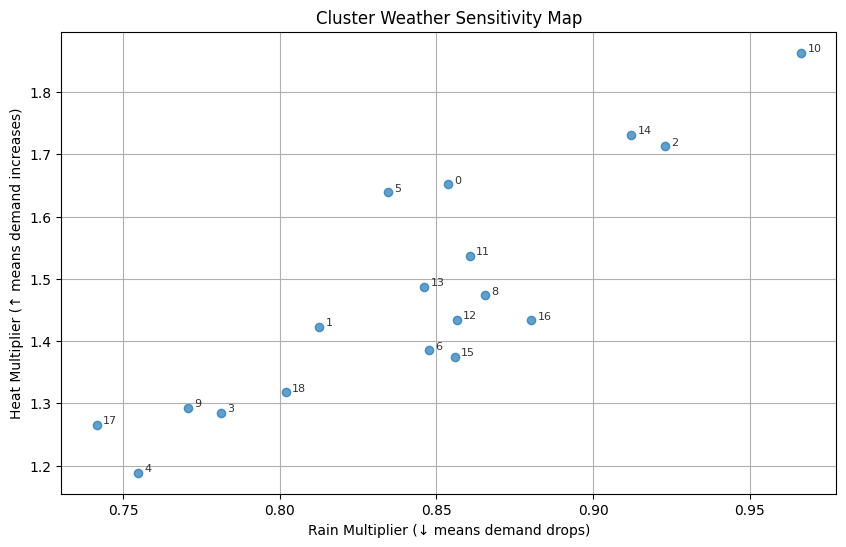

In [12]:
plt.figure(figsize=(10,6))

plt.scatter(
    cluster_sensitivity["rain_multiplier"],
    cluster_sensitivity["heat_multiplier"],
    alpha=0.7
)

for _, row in cluster_sensitivity.iterrows():
    plt.text(
    row["rain_multiplier"] + 0.002,
    row["heat_multiplier"] + 0.002,
    str(int(row["cluster_id"])),
    fontsize=8, alpha=0.8
)

plt.xlabel("Rain Multiplier (↓ means demand drops)")
plt.ylabel("Heat Multiplier (↑ means demand increases)")
plt.title("Cluster Weather Sensitivity Map")
plt.grid(True)
plt.show()


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    7. Operational Scenario Lookup – Cluster-Level Weather Response
  </span>
</h3>

In this step we build a small “operational API” that allows the user (or a 
dashboard) to query expected demand for **any cluster under any weather 
scenario**.

The function takes three inputs:

- **cluster_id** – the spatial cluster of interest  
- **temp_C** – the current temperature  
- **rain_flag** – `"dry"`, `"rain"`, or `"snow"`

The temperature is automatically mapped to the corresponding **temperature bin** 
(e.g., `<0`, `0–5`, `5–10`, `10–15`, …).  
Using this bin and the rain flag, the function retrieves the appropriate 
multiplier from the scenario table and computes:

- the expected pickups = baseline × multiplier  
- the scenario multiplier  
- the baseline demand for the cluster  
- and an optional quick visualisation.

This creates a practical, real-time-ready tool that can be used by an operator 
to check how weather conditions affect demand at individual clusters.


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    7.1 – Scenario Confidence & Validation Using Historical Support (n_hours)
  </span>
</h3>

Each cluster–weather scenario is supported by a different number of historical
observations (stored in <code>n_hours</code>).  
This matters because a multiplier computed from only a few hours is less
statistically reliable.

In this step, we enhance the lookup function by:

- Adding the scenario’s <b>historical support</b> (<code>n_hours</code>) to the output.
- Issuing a <b>warning</b> when the scenario is based on limited data
  (e.g., fewer than 30–40 hours).
- Coloring the bar plot according to confidence level:
  - <span style="color:#2a7b2a; font-weight:bold;">Green</span>: high confidence  
  - <span style="color:#c87f00; font-weight:bold;">Orange</span>: medium confidence  
  - <span style="color:#b30000; font-weight:bold;">Red</span>: low confidence  

This makes the operational lookup robust and transparent:  
the user immediately knows whether a scenario is well-supported or based on
sparse historical conditions.

In [ ]:
# map real temperature to temp_bin 
def map_temp_to_bin(t):
    if t < 0:     return "<0"
    if t < 5:     return "0-5"
    if t < 10:    return "5-10"
    if t < 15:    return "10-15"
    if t < 20:    return "15-20"
    if t < 25:    return "20-25"
    if t < 30:    return "25-30"
    return ">30"

def query_cluster_weather(cluster_id, temp_C, rain_flag, day_type="weekday",
                          pretty=True, plot=False):
    """
    Return expected pickups + reliability score for
    (cluster_id, temperature, rain_flag, day_type).
    Includes n_hours validation and confidence warnings.
    """

    # Map temperature into bin 
    tb = map_temp_to_bin(temp_C)

    # Select matching scenario row 
    mask = (
        (scenario_table_clean["cluster_id"] == cluster_id) &
        (scenario_table_clean["temp_bin"] == tb) &
        (scenario_table_clean["rain_flag"] == rain_flag) &
        (scenario_table_clean["day_type"] == day_type)
    )

    sub = scenario_table_clean[mask]

    if sub.empty:
        return f"[NO DATA] No scenario found for cluster={cluster_id}, temp_bin={tb}, rain={rain_flag}, day={day_type}"

    row = sub.iloc[0]

    baseline = float(row["baseline_mean"])
    mult = float(row["multiplier"])
    expected = baseline * mult
    n_hours = int(row["n_hours"])

    #  Determine confidence level 
    if n_hours >= 80:
        confidence = "high"
        color = "green"
    elif n_hours >= 30:
        confidence = "medium"
        color = "orange"
    else:
        confidence = "low"
        color = "red"

    result = {
        "cluster_id": int(cluster_id),
        "input_temp_C": float(temp_C),
        "temp_bin": tb,
        "rain_flag": rain_flag,
        "day_type": day_type,
        "baseline_mean": baseline,
        "multiplier": mult,
        "expected_pickups": expected,
        "n_hours": n_hours,
        "confidence": confidence
    }

    #  Plain version (e.g., for API) 
    if not pretty and not plot:
        return result

    #  Pretty printed version 
    pretty_out = f"""
=====================================
   CLUSTER WEATHER LOOKUP RESULT
=====================================
 Cluster ID:            {result['cluster_id']}
 Temperature:           {result['input_temp_C']}°C → bin {result['temp_bin']}
 Rain flag:             {result['rain_flag']}
 Day type:              {result['day_type']}

 Baseline pickups:      {baseline:.1f}
 Weather multiplier:    {mult:.3f}
 ------------------------------------
 EXPECTED pickups:      {expected:.1f}

 Historical support:    {n_hours} hours
 Confidence level:      {confidence.upper()}
=====================================
"""
    print(pretty_out)

    # --- Optional visualization ---
    if plot:
        plt.figure(figsize=(5,4))
        plt.bar(
            ["baseline", f"{rain_flag} @ {tb}"],
            [baseline, expected],
            color=["gray", color]
        )
        plt.title(f"Cluster {cluster_id} – Scenario effect ({confidence} confidence)")
        plt.ylabel("Pickups")
        plt.grid(axis="y", alpha=0.3)
        plt.show()

    return result


   CLUSTER WEATHER LOOKUP RESULT
 Cluster ID:            15
 Temperature:           -3.0°C → bin <0
 Rain flag:             snow
 Day type:              weekday

 Baseline pickups:      244.6
 Weather multiplier:    0.300
 ------------------------------------
 EXPECTED pickups:      73.4

 Historical support:    47 hours
 Confidence level:      MEDIUM



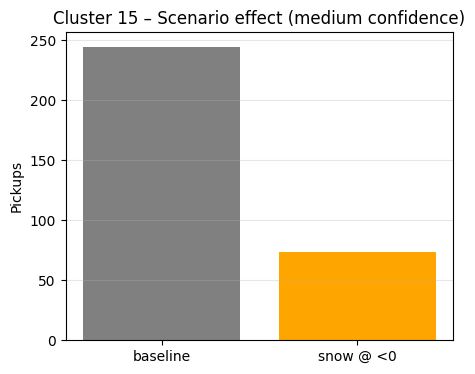


   CLUSTER WEATHER LOOKUP RESULT
 Cluster ID:            4
 Temperature:           27.0°C → bin 25-30
 Rain flag:             dry
 Day type:              weekend

 Baseline pickups:      279.5
 Weather multiplier:    0.776
 ------------------------------------
 EXPECTED pickups:      216.8

 Historical support:    232 hours
 Confidence level:      HIGH



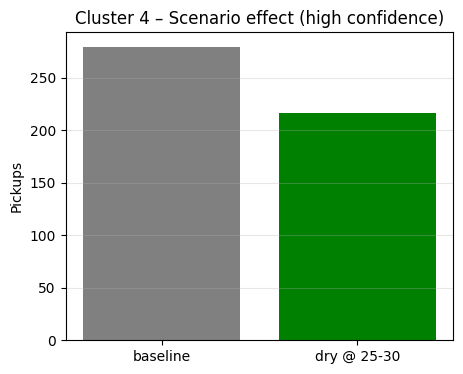

{'cluster_id': 4,
 'input_temp_C': 27.0,
 'temp_bin': '25-30',
 'rain_flag': 'dry',
 'day_type': 'weekend',
 'baseline_mean': 279.5009633911368,
 'multiplier': 0.7756434926662245,
 'expected_pickups': 216.79310344827587,
 'n_hours': 232,
 'confidence': 'high'}

In [14]:
query_cluster_weather(7, 12, "rain", plot=True)
query_cluster_weather(15, -3, "snow",plot=True)
query_cluster_weather(4, 27, "dry", day_type="weekend",plot=True)


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    7.2 – Weather Response Matrix per Cluster (Scenario Grid)
  </span>
</h3>

This matrix summarises a cluster's expected behaviour across all major
weather conditions.

For each cluster, we build a pivot-style table:

- Rows: temperature bins (<0, 0–5, 5–10, …)
- Columns: weather types (dry, rain, snow)
- Values: expected pickups (baseline × multiplier)

This creates a compact operational "cheat sheet" showing how the cluster 
responds under all common weather scenarios.

Such a matrix is ideal for:
- dashboards,
- summary tables in the report,
- automated operational decision-making,
- comparing clusters side-by-side.


In [ ]:
# Build scenario matrix for a given cluster --- #

def cluster_scenario_matrix(cluster_id, day_type="weekday"):
    """
    Returns a matrix (temp_bin × rain_flag) with expected pickups for a cluster.
    """

    df = scenario_table_clean.copy()

    # Filter only cluster + day_type
    sub = df[
        (df["cluster_id"] == cluster_id) &
        (df["day_type"] == day_type)
    ]

    if sub.empty:
        return f"[NO DATA] No scenarios for cluster {cluster_id} ({day_type})"

    # Pivot: rows = temp_bin, columns = rain/dry/snow, values = expected pickups
    sub["expected"] = sub["scenario_mean"]   # convenience

    matrix = sub.pivot_table(
        index="temp_bin",
        columns="rain_flag",
        values="expected",
        aggfunc="mean"
    )

    # Order rows (temperature bins)
    temp_order = ["<0", "0-5", "5-10", "10-15", "15-20", "20-25", "25-30", ">30"]
    matrix = matrix.reindex(temp_order)

    return matrix


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    7.3 – Multi-Cluster Scenario Matrix & Heatmap Visualization
  </span>
</h3>

This step visualizes the complete weather–demand response for any cluster.</br>
For a chosen <code>cluster_id</code> and <code>day_type</code>, we build a matrix </br>
(<em>temperature bin × weather condition</em>) showing the expected pickups for each scenario.

A heatmap is then generated to highlight how sensitive the cluster is to:
- temperature changes (cold vs warm vs hot),  
- weather effects (dry / rain / snow).

This helps identify clusters that are heat-sensitive, rain-sensitive, or stable across conditions, 
supporting operational planning and targeted rebalancing.

In [ ]:
# Multi-Cluster Scenario Matrix + Heatmap Visualization --- #

import seaborn as sns
import matplotlib.pyplot as plt

def show_cluster_matrix_with_heatmap(cluster_id, day_type="weekday"):
    """
    Prints the scenario matrix for a cluster and plots it as a heatmap.
    """
    print(f"\n==============================")
    print(f"   SCENARIO MATRIX – CLUSTER {cluster_id} ({day_type})")
    print(f"==============================")

    matrix = cluster_scenario_matrix(cluster_id, day_type)

    # Print matrix (table)
    display(matrix)

    # If matrix is numeric → plot heatmap
    if isinstance(matrix, pd.DataFrame):
        plt.figure(figsize=(6,4))
        sns.heatmap(
            matrix,
            annot=True,
            fmt=".0f",
            cmap="YlGnBu",
            linewidths=0.5
        )
        plt.title(f"Cluster {cluster_id} – Weather Response Heatmap ({day_type})")
        plt.ylabel("Temperature bin")
        plt.xlabel("Weather type")
        plt.tight_layout()
        plt.show()





   SCENARIO MATRIX – CLUSTER 15 (weekday)


C:\Users\Georg\AppData\Local\Temp\ipykernel_22260\1462811427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["expected"] = sub["scenario_mean"]   # convenience


rain_flag,dry,rain,snow
temp_bin,,,
<0,112.556886,NaN,73.404255
0-5,180.918418,107.661458,NaN
5-10,199.465253,159.036199,NaN
10-15,243.556989,201.805556,NaN
15-20,296.033808,239.509934,NaN
20-25,297.188787,292.971429,NaN
25-30,300.915954,327.315789,NaN
>30,383.164444,367.560976,NaN


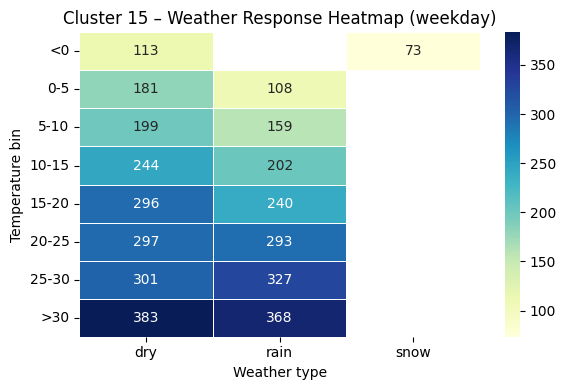


   SCENARIO MATRIX – CLUSTER 4 (weekend)


C:\Users\Georg\AppData\Local\Temp\ipykernel_22260\1462811427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["expected"] = sub["scenario_mean"]   # convenience


rain_flag,dry,rain
temp_bin,,
<0,71.500000,NaN
0-5,107.617761,65.903226
5-10,138.623978,79.744681
10-15,135.376518,136.049587
15-20,202.651452,122.055556
20-25,189.832117,167.457627
25-30,216.793103,NaN
>30,234.318182,NaN


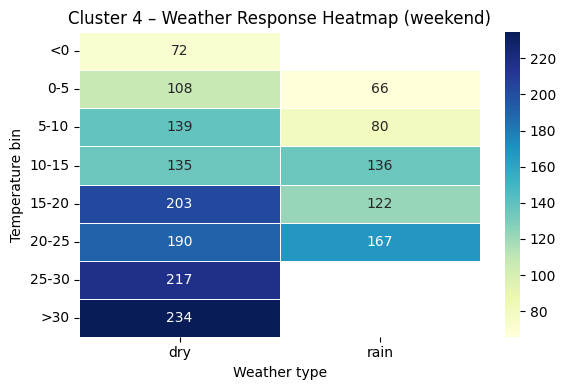


   SCENARIO MATRIX – CLUSTER 7 (weekday)


'[NO DATA] No scenarios for cluster 7 (weekday)'


   SCENARIO MATRIX – CLUSTER 2 (weekday)


C:\Users\Georg\AppData\Local\Temp\ipykernel_22260\1462811427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["expected"] = sub["scenario_mean"]   # convenience


rain_flag,dry,rain,snow
temp_bin,,,
<0,40.709375,NaN,30.418605
0-5,65.656051,39.529730,NaN
5-10,78.952785,62.070423,NaN
10-15,100.403930,79.137441,NaN
15-20,129.208633,101.496644,NaN
20-25,130.113662,124.931429,NaN
25-30,137.118402,152.649123,NaN
>30,188.897778,184.365854,NaN


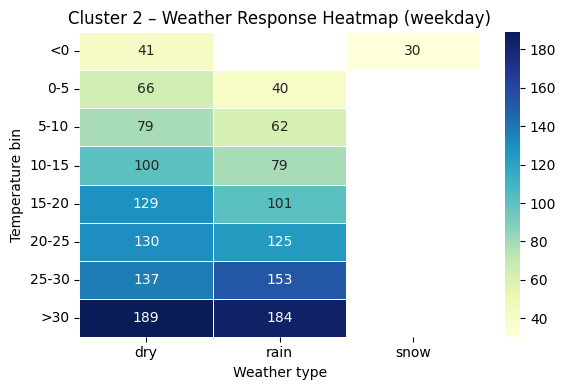


   SCENARIO MATRIX – CLUSTER 10 (weekday)


C:\Users\Georg\AppData\Local\Temp\ipykernel_22260\1462811427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["expected"] = sub["scenario_mean"]   # convenience


rain_flag,dry,rain,snow
temp_bin,,,
<0,11.875421,NaN,8.487179
0-5,17.349398,10.918605,NaN
5-10,21.596491,16.355769,NaN
10-15,27.188764,21.048780,NaN
15-20,35.838532,27.760274,NaN
20-25,40.564460,36.856322,NaN
25-30,43.266955,43.500000,NaN
>30,57.844444,55.487805,NaN


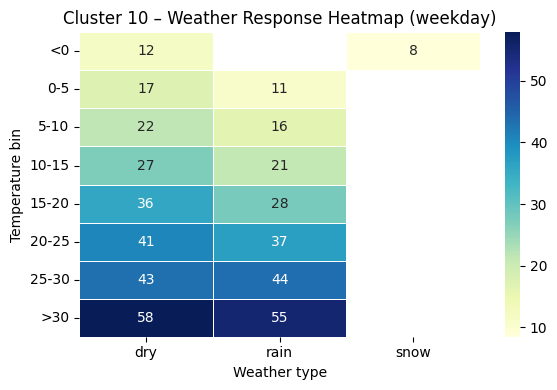

In [17]:
# === Examples for different clusters === #

# Example A – A cold-sensitive cluster
show_cluster_matrix_with_heatmap(cluster_id=15, day_type="weekday")

# Example B – A heat-sensitive cluster
show_cluster_matrix_with_heatmap(cluster_id=4, day_type="weekend")

# Example C – A more neutral cluster
show_cluster_matrix_with_heatmap(cluster_id=7, day_type="weekday")

# Example D – Random other clusters for exploration
show_cluster_matrix_with_heatmap(cluster_id=2)
show_cluster_matrix_with_heatmap(cluster_id=10)

<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee; padding:8px; border-radius:5px; font-size:20px;">
    7.4 – Mini Operational Dashboard (Batch Scenarios)
  </span>
</h3>

In this final step we turn the lookup function into a small “dashboard”.  </br>
We define a list of typical scenarios (cluster, temperature, weather, day type) and,</br>
for each one, we call <code>query_cluster_weather()</code> with <code>pretty=False</code> to get a</br>
machine-friendly dictionary.

All scenarios are collected into a single <code>DataFrame</code> that shows, side by side:

- cluster id and day type,  
- input temperature and mapped <code>temp_bin</code>,  
- weather flag (dry / rain / snow),  
- baseline demand, multiplier and expected pickups,  
- historical support (<code>n_hours</code>) and confidence level.

This table can be used directly in the report as an example dashboard, or as a</br>
starting point for a simple UI where an operator chooses a scenario and reads the</br>
corresponding expected demand.


In [18]:
# Mini operational dashboard (batch scenarios) --- #

def build_cluster_weather_dashboard(cases):
    """
    Given a list of scenario dictionaries, run query_cluster_weather()
    for each one (without pretty-print) and collect the results in a DataFrame.
    """
    rows = []
    for c in cases:
        res = query_cluster_weather(
            cluster_id=c["cluster_id"],
            temp_C=c["temp_C"],
            rain_flag=c["rain_flag"],
            day_type=c.get("day_type", "weekday"),
            pretty=False,
            plot=False,
        )
        # Skip scenarios with no data
        if isinstance(res, dict):
            rows.append(res)
        else:
            print(res)  # prints [NO DATA] message

    return pd.DataFrame(rows)


# Example scenarios for the dashboard
dashboard_cases = [
    {"cluster_id": 15, "temp_C": -3,  "rain_flag": "snow", "day_type": "weekday"},
    {"cluster_id": 15, "temp_C": 22,  "rain_flag": "dry",  "day_type": "weekday"},
    {"cluster_id": 4,  "temp_C": 27,  "rain_flag": "dry",  "day_type": "weekend"},
    {"cluster_id": 4,  "temp_C": 12,  "rain_flag": "rain", "day_type": "weekday"},
    {"cluster_id": 7,  "temp_C": 8,   "rain_flag": "rain", "day_type": "weekday"},
]

cluster_weather_dashboard = build_cluster_weather_dashboard(dashboard_cases)

print("Operational dashboard scenarios:")
display(cluster_weather_dashboard)


[NO DATA] No scenario found for cluster=7, temp_bin=5-10, rain=rain, day=weekday
Operational dashboard scenarios:


,cluster_id,input_temp_C,temp_bin,rain_flag,day_type,baseline_mean,multiplier,expected_pickups,n_hours,confidence
0,15,-3.0,<0,snow,weekday,244.601156,0.300098,73.404255,47,medium
1,15,22.0,20-25,dry,weekday,244.601156,1.214993,297.188787,874,high
2,4,27.0,25-30,dry,weekend,279.500963,0.775643,216.793103,232,high
3,4,12.0,10-15,rain,weekday,279.500963,0.850552,237.730233,215,high


<h3>
  <span style="color:green; font-weight:bold; background-color:#eef7ee;
               padding:8px; border-radius:5px; font-size:20px;">
    7.5 – Export Cluster–Weather Scenario Dataset (Final Export)
  </span>
</h3>

In this final step we export all weather–response outputs so that the entire
pipeline can be reused in downstream notebooks or dashboards.

We export:

1. **Cluster–Weather Scenario Table**  
   (`scenario_table_clean.csv`)  
   – contains all (cluster, temp_bin, rain_flag, day_type, multiplier) entries

2. **Cluster Sensitivity Table**  
   (`cluster_weather_sensitivity.csv`)  
   – heat/rain/cold multipliers + elasticity score per cluster

3. **Operational Dashboard Examples**  
   (`dashboard_examples.csv`)  
   – multiple lookup results for demo and validation purposes

All exports make the weather-impact model fully reproducible and portable.


In [ ]:
import os

# Create export directory
export_dir = "../data/Weather_Data/model_outputs/"
os.makedirs(export_dir, exist_ok=True)

path_scenarios = os.path.join(export_dir, "scenario_table_clean.csv")
path_sensitivity = os.path.join(export_dir, "cluster_weather_sensitivity.csv")
path_dashboard = os.path.join(export_dir, "dashboard_examples.csv")

print("Saving outputs to:", export_dir)

#  1. Export scenario table 
scenario_table_clean.to_csv(path_scenarios, index=False)

#  2. Export cluster sensitivity table 
cluster_sensitivity.to_csv(path_sensitivity, index=False)

#  3. Optional: small dashboard example set 
dashboard_examples = pd.DataFrame([
    query_cluster_weather(15, -3,  "snow", day_type="weekday", pretty=False),
    query_cluster_weather(15, 22,  "dry",  day_type="weekday", pretty=False),
    query_cluster_weather(4,  27,  "dry",  day_type="weekend", pretty=False),
    query_cluster_weather(4,  12,  "rain", day_type="weekday", pretty=False),
])

dashboard_examples.to_csv(path_dashboard, index=False)

print("\n=== EXPORT COMPLETE ===")
print("-", path_scenarios)
print("-", path_sensitivity)
print("-", path_dashboard)


Saving outputs to: ../data/Weather_Data/model_outputs/

=== EXPORT COMPLETE ===
- ../data/Weather_Data/model_outputs/scenario_table_clean.csv
- ../data/Weather_Data/model_outputs/cluster_weather_sensitivity.csv
- ../data/Weather_Data/model_outputs/dashboard_examples.csv
